In [1]:
#IMPORTS
!python --version

import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd

import os
from os import path
import math
import matplotlib.pyplot as plt

import keras
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dense, LSTM, Dropout, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD, Adam
from keras import backend as K

from sklearn.model_selection import train_test_split  
from functools import partial

%matplotlib inline
np.random.seed(7)

Python 3.9.13


2023-04-20 17:01:09.476037: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from tensorflow.keras.layers import *

In [3]:
##Code to obtain indexes of plays with video recording errors! (Essential in cleaning dataset)
df = pd.read_csv('Video-Watching-Results-Nevin_-Pedro_-Pranav_-Ryan_-Saahil_-Tawfiq.csv') 
plays = np.load('./stadium-iopt/numpy_data/plays.npy', allow_pickle=True)
newD = df[["Class", "File"]]
p = newD.loc[newD['Class'] == "14"]
q = newD.loc[newD['Class'] == "13"]
k = newD.loc[newD['Class'] == "12"]
j = newD.loc[newD['Class'] == "151"]
o = newD.loc[newD['Class'] == "152"]
p = pd.concat([p,q,k,j,o], axis=0)
l =p["File"].tolist()
for idx in range(len(l)):
    arr = l[idx].split("/")
    l[idx] = ""
    l[idx] = arr[1][1:] + "_" + arr[2][1:] + "_" + arr[4][0:3]
indices = []
for elem in l:
    val = np.where(plays == elem)[0]
    if len(val) > 0: 
        indices.append(val)
    

indices = np.array(indices)




In [4]:
# Code to obtain the indexes of plays from the 2017 season (very low quality) as part of our optimizations
plays_df = pd.DataFrame(data=plays).apply(lambda x: x.str[:4])
idx_2017 = plays_df[plays_df[0].isin(['6016','6017'])].index

In [5]:
##Loading pregenerated numpy files (created in Data Preprocessing Notebook)
labels = np.load('./stadium-iopt/numpy_data/one_hot_labels.npy', allow_pickle=True)
print(labels.shape)
indexes = np.load('./stadium-iopt/numpy_data/sample_indexes.npy', allow_pickle=True)
print(indexes.shape)
plays = np.load('./stadium-iopt/numpy_data/plays.npy', allow_pickle=True)
print(plays.shape)

#Removing those plays (low quality 2017 + video recording errors) to form the clean labels array
labels_df = pd.DataFrame(data=labels)
# print(labels_df[100:150])
#labels_df[4][labels_df[5] == 1.0] = 1.0
labels_df[3][labels_df[4] == 1.0] = 1.0
del labels_df[4]
# print(labels_df[100:150])
labels = labels_df.to_numpy()
labels = labels[[i for i in range(len(plays)) if plays[i] not in l and i not in idx_2017]]
# plays = plays[[i for i in range(len(plays)) if plays[i] not in l and i not in idx_2017]]
#remove 'if plays[i] not in l and' if u want to keep all plays!!!
# print(plays.shape)

(5647, 6)
(1129,)
(5647,)


In [6]:
##Loading and cleaning the pregenerated output of the resnet cnn model as a numpy file
resnet_cnn_images = np.load('./stadium-iopt/numpy_data/resnet_cnn_images.npy', allow_pickle=True)
cnn_images = resnet_cnn_images[[i for i in range(len(plays)) if i not in idx_2017 and plays[i] not in l]]
plays = plays[[i for i in range(len(plays)) if plays[i] not in l and i not in idx_2017]]
cnn_images.shape

(4722,)

In [7]:
#Creating train and test samples
print(len(cnn_images))
print(len(plays))
train_idx = np.random.choice(len(cnn_images), size=int(len(cnn_images) * 0.7), replace=False)
test_idx = list(set(train_idx) ^ set([x for x in range(len(cnn_images))]))
# print(train_idx)
# print(test_idx)
X_train = cnn_images[train_idx]
X_test = cnn_images[test_idx]
y_train = labels[train_idx]
y_test = labels[test_idx]

X_train_pad = sequence.pad_sequences(X_train, maxlen=30)
X_test_pad = sequence.pad_sequences(X_test, maxlen=30)
inputDim = 2048

4722
4722


In [9]:
##Loading plays_csv and videos_csv which contain essential information about a play (importantly down, play type, yards to go)
videos_csv = pd.read_csv('./play_data/Video.csv',sep=';')
plays_csv = pd.read_csv('./play_data/Play.csv',sep=';')
###Loading dataframe that provides information about a play (used to retrieve key information about past play)
training_labels = pd.merge(plays_csv.iloc[:,[0,1,2,3,4,5,9,10]], videos_csv[['VideoFileName','VideoPath','PlayID','GameID']],left_on='ID', right_on='PlayID')
training_labels = training_labels[training_labels.Type.isin(['K', 'R', 'P', 'X', 'F', 'U'])]
training_labels['wholeName'] = training_labels['VideoPath'] + training_labels['VideoFileName']
training_labels
for idx in training_labels.index:
    arr = training_labels['wholeName'][idx].split("/")
    training_labels['wholeName'][idx] = ""
    training_labels['wholeName'][idx] = arr[1][1:] + "_" + arr[2][1:] + "_" + arr[3][0:3]
training_labels['wholeName']['5968_3_37'] = '5968_3_037'
training_labels.index = training_labels['wholeName']  
training_labels = training_labels.drop_duplicates(keep='first')
spotTemp = training_labels['Spot']
l = []
for elem in spotTemp:
    l.append(elem[:-1] + "0")
training_labels['Spot'] = l
training_labels


,ID,Down,ToGo,Spot,Text,Quarter,HasBall,Type,VideoFileName,VideoPath,PlayID,GameID,wholeName
wholeName,,,,,,,,,,,,,
3_1_000,11,2.0,3,H20,"2nd & 3 at OSU24: Saine, Brandon rush for 11 y...",1,V,R,000,2009/G3/Q1/,11,3,3_1_000
3_1_003,11,2.0,3,H20,"2nd & 3 at OSU24: Saine, Brandon rush for 11 y...",1,V,R,003,2009/G3/Q1/,11,3,3_1_003
3_1_002,15,1.0,0,H00,"1st & GOAL at OSU03: Pettrey, Aaron kick attem...",1,V,X,002,2009/G3/Q1/,15,3,3_1_002
4_1_012,18,1.0,10,H20,"1st & 10 at OSU26: Masoli, J. pass complete to...",1,H,P,012,2009/G4/Q1/,18,4,4_1_012
4_1_027,38,1.0,10,H00,"1st & 10 at OSU09: James, L. rush for loss of ...",1,H,R,027,2009/G4/Q1/,38,4,4_1_027
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6017_4_035,15479,1.0,10,V40,"1st & 10 at UNC43: Surratt, C rush for 5 yards...",4,V,R,035,2017/G6017/Q4/,15479,6017,6017_4_035
6017_4_036,15480,2.0,5,V40,"2nd & 5 at UNC48: Surratt, C pass incomplete t...",4,V,P,036,2017/G6017/Q4/,15480,6017,6017_4_036
6017_4_037,15481,3.0,5,V40,"3rd & 5 at UNC48: Surratt, C pass complete to ...",4,V,P,037,2017/G6017/Q4/,15481,6017,6017_4_037


In [10]:
##Loading Markov Model: Down, Type, and Field Position Matrix
df = pd.read_csv('DownTypeFPDist.csv') 
l = df['Unnamed: 0']
newL = []
for elem in l:
    newL.append(elem)
#['K', 'R', 'P', 'X/F', 'U']
df['X/F'] = df['X'] + df['F']
df = df[['K', 'R', 'P', 'X/F', 'U']]
df['New'] = newL
df.index = df['New']
del df['New']
df

,K,R,P,X/F,U
New,,,,,
1&1-3 R@H00,0.000000,0.000000,0.000000,0.0,0.0
1&4-6 R@H00,0.000000,1.000000,0.000000,0.0,0.0
1&7-9 R@H00,0.000000,1.000000,0.000000,0.0,0.0
1&10-14 R@H00,0.045614,0.649123,0.305263,0.0,0.0
1&15-19 R@H00,0.000000,0.500000,0.500000,0.0,0.0
...,...,...,...,...,...
4&4-6 O@V00,0.000000,0.000000,0.000000,0.0,0.0
4&7-9 O@V00,0.000000,0.000000,0.000000,0.0,0.0
4&10-14 O@V00,0.000000,0.000000,0.000000,0.0,0.0


In [11]:
##calculating 5elem markov vector for each play in the train data!
ret = []
ct = 0
l = training_labels['wholeName']
for elem in plays[train_idx]:
    if any(c.isalpha() for c in elem): 
        ct += 1
        ret.append(np.array([0.2, 0.2, 0.2, 0.2, 0.2]))
        continue
    elif elem[-2] == "h":
        elem = elem[:-3]
    elif elem[-3] == "_":
        elem = elem[:-3] + "_0" + str(int(elem[-2:]))
 
    prev = None
    i = int(elem[-3:]) -1 
    if i < 10:
        prev = elem[:-3] + "00" + str(int(elem[-3:]) -1)
    elif i < 100:
        prev = elem[:-3] + "0" + str(int(elem[-3:]) -1)
    if prev in l:
        down = int(training_labels.loc[prev]['Down'])
        fp = training_labels.loc[prev]['Spot'] 
        typ = training_labels.loc[prev]['Type'] 
        txt = training_labels.loc[prev]['Text'] 
        dist = int(training_labels.loc[prev]['ToGo'])
        distStr = ""
        if dist <= 3: 
            distStr = "&1-3"
        elif dist <= 6: 
            distStr = "&4-6"
        elif dist <= 9: 
            distStr = "&7-9"
        elif dist <= 14: 
            distStr = "&10-14"
        elif dist <= 19: 
            distStr = "&15-19"
        else:
            distStr = "&20-99"  
        key = str(down) + distStr + " " + str(typ) + "@" + fp 
        if key[-2] == "5":
            key = key[:-2] + "4" + key[-1]
        if "TOUCHDOWN" in txt: 
            markov = [0, 0, 0, 1, 0]
        elif "kick attempt good" in txt: 
            markov = [1, 0, 0, 0, 0]
        else:
            markov = np.array(df.loc[key])
        ret.append(markov)
    else:
        ret.append(np.array([0.2, 0.2, 0.2, 0.2, 0.2]))
ret = np.array(ret)   
trainMarkov = ret
trainMarkov

array([[0.        , 0.66071429, 0.29761905, 0.04166667, 0.        ],
       [0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.00456621, 0.52968037, 0.24657534, 0.01369863, 0.20547945],
       ...,
       [0.        , 0.35042735, 0.64102564, 0.00854701, 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.41520468, 0.52631579, 0.05847953, 0.        ]])

In [12]:
##calculating 5elem markov vector for each play in the test data!
ret = []
ct = 0
l = training_labels['wholeName']
for elem in plays[test_idx]:
    if any(c.isalpha() for c in elem): 
        ct += 1
        ret.append(np.array([0.2, 0.2, 0.2, 0.2, 0.2]))
        continue
    elif elem[-2] == "h":
        elem = elem[:-3]
    elif elem[-3] == "_":
        elem = elem[:-3] + "_0" + str(int(elem[-2:]))
 
    prev = None
    i = int(elem[-3:]) -1 
    if i < 10:
        prev = elem[:-3] + "00" + str(int(elem[-3:]) -1)
    elif i < 100:
        prev = elem[:-3] + "0" + str(int(elem[-3:]) -1)
    if prev in l:
        down = int(training_labels.loc[prev]['Down'])
        fp = training_labels.loc[prev]['Spot'] 
        typ = training_labels.loc[prev]['Type'] 
        txt = training_labels.loc[prev]['Text']
#         if '1ST' in playDesArr:
#             nextDown = 1
#             dist = 10
        print(txt)
        dist = int(training_labels.loc[prev]['ToGo'])
        distStr = ""
        if dist <= 3: 
            distStr = "&1-3"
        elif dist <= 6: 
            distStr = "&4-6"
        elif dist <= 9: 
            distStr = "&7-9"
        elif dist <= 14: 
            distStr = "&10-14"
        elif dist <= 19: 
            distStr = "&15-19"
        else:
            distStr = "&20-99"  
        key = str(down) + distStr + " " + str(typ) + "@" + fp 
        if key[-2] == "5":
            key = key[:-2] + "4" + key[-1]
        if "TOUCHDOWN" in txt: 
            markov = [0, 0, 0, 1, 0]
        elif "kick attempt good" in txt: 
            markov = [1, 0, 0, 0, 0]
        else:
            markov = np.array(df.loc[key])
        ret.append(markov)
    else:
        ret.append(np.array([0.2, 0.2, 0.2, 0.2, 0.2]))
ret = np.array(ret)   
testMarkov = ret
testMarkov

2nd & 1 at GT19: JORDON,Asheton rush for no gain to the GT19 (Cross, I.).
3rd & 1 at GT19: MASSEY,Chris rush for 2 yards to the GT17, 1ST DOWN NCST (Taylor, C.;Peters, J.).
1st & 10 at GT50: Allen, A. rush for 9 yards to the NCST41 (WILKERSON,Juliu).
2nd & 10 at NCST26: MASSEY,Chris rush for 2 yards to the NCST28 (Cross, I.;Egbuniwe, A.).
2nd & 15 at GT15: Washington, T. rush for 4 yards to the GT19 (ERBY, David;RICHARD,Donovan).
4th & 1 at NCST49: JORDON,Asheton rush for 1 yard to the 50 yardline, 1ST DOWN NCST (Cross, I.;Egbuniwe, A.).
2nd & 5 at GT25: Washington, T. rush for 4 yards to the GT29 (AYERS,Jason).
1st & 10 at GT18: Greene, M. rush for 2 yards to the GT16 (Jefferson, B.;Peters, J.).
1st & 10 at UVA30: Hinkebein,C kickoff 70 yards to the GT0, Peeples, E. return 27 yards to the GT27 (Keys,R).
2nd & 3 at UVA48: Cox, L. rush for 11 yards to the UVA37, 1ST DOWN GT (Mosley,C).
2nd & 8 at UVA35: Nesbitt, J. rush for 1 yard to the UVA34 (Greer,S;Jenkins,N).
1st & 10 at UVA34: Ver

4th & 5 at GT34: Poole, S. punt 40 yards to the WCAR26, Deja Alexander return 13 yards to the WCAR39 (Burnett, J.).
4th & 4 at WCAR45: Blake Cain punt 37 yards to the GT18, fair catch by Laskey, Z..
1st & 10 at GT47: Gary Green rush for loss of 9 yards to the WCAR44 (Peterson, M.;Young, L.).
2nd & 9 at WCAR28: Days, S. rush for 4 yards to the WCAR24 (Chris Everett;Andre Shishkin).
1st & 10 at WCAR19: Perkins, C. rush for 2 yards to the WCAR17 (Rainey Ala;Andre Shishkin).
1st & GOAL at GT30: Scully, D. kickoff 58 yards to the WCAR12, G. Richardson return 19 yards to the WCAR31 (Scully, D.).
3rd & 7 at WCAR39: Godhigh, R. rush for 6 yards to the WCAR33 (Dee Williams;Trey Selby).
1st & 10 at WCAR33: Petey Boone rush for 33 yards to the GT34, 1ST DOWN WCAR (Young, L.).
2nd & 10 at WCAR41: Sims, D. rush for 5 yards to the WCAR36 (Andre Shishkin;Trey Selby).
3rd & 21 at GT25: Washington, T. rush for 10 yards to the GT35 (Marcus Stokes).
1st & GOAL at GT02: B. Pechloff rush for 2 yards to the

2nd & 9 at GT48: Washington, T. rush for 35 yards to the VT17, 1ST DOWN GT (Whitley, E).
3rd & 6 at VT13: Lyons, P. rush for 10 yards to the VT3, 1ST DOWN GT (Hopkins, D;Whitley, E).
2nd & GOAL at VT01: Washington, T. rush for 1 yard to the VT0, TOUCHDOWN, clock 11:17.
1st & GOAL at GT30: Scully, D. kickoff 68 yards to the VT2, Gregory, T return 21 yards to the VT23 (Perkins, C.;Thomas, J.), PENALTY VT personal foul (Beiro, R) 11 yards to the VT12, 1st and 10, VT ball on VT12.
2nd & 12 at VT10: Thomas, L pass incomplete to Boykin, J, dropped pass.
3rd & 12 at VT10: Thomas, L pass complete to Coale, D for 34 yards to the VT44, 1ST DOWN VT.
3rd & 11 at VT43: Thomas, L pass complete to Coles, DJ for 38 yards to the GT19, 1ST DOWN VT (Sweeting, R.;Johnson, I.).
1st & 10 at GT19: Wilson, D rush for 3 yards to the GT16, fumble forced by Burnett, J., fumble by Wilson, D recovered by GT Johnson, I. at GT16.
1st & 10 at VT30: Washington, T. rush for 29 yards to the VT1, 1ST DOWN GT, out-of-boun

1st & 10 at GT49: Shepherd,K rush for 4 yards to the GT45 (Travis, K.).
2nd & 6 at GT45: Shepherd,K rush for 9 yards to the GT36, 1ST DOWN UVA (Munroe, M.).
3rd & 13 at GT39: Shepherd,K rush for 14 yards to the GT25, 1ST DOWN UVA (Milton, C.).
1st & GOAL at GT07: Sims,P pass complete to Severin,C for 3 yards to the GT4 (Travis, K.).
2nd & GOAL at GT04: Sims,P pass complete to McGee,J for 3 yards to the GT1 (Carlson, C.).
2nd & 9 at GT06: Bostic, B. rush for 9 yards to the GT15, 1ST DOWN GT (Johnson, E).
1st & 10 at GT35: Laskey, Z. rush for 2 yards to the GT37 (Robinson, L;Cornileus, T).
3rd & 10 at GT21: Wieclaw, J field goal attempt from 38 GOOD, clock 04:11.
1st & GOAL at GT20: Poole, S. kickoff 39 yards to the MIA41, James, M return 11 yards to the GT48 (Hill, D.;Johnson, I.).
2nd & 10 at GT48: Morris, S rush for 7 yards to the GT41 (Green, S.).
1st & GOAL at MIA07: Washington, T. rush for loss of 1 yard to the MIA8 (Johnson, E;Pierre, O).
1st & GOAL at GT35: Scully, D. kickoff 65 

1st & 10 at BC41: Rettig,C sacked for loss of 2 yards to the BC39 (Cummings, E.).
2nd & 12 at BC39: Rettig,C pass incomplete to Williams,A.
1st & 10 at GT42: NELSON, Riley pass incomplete to MENDENHALL, Zed.
3rd & 2 at GT06: WILLIAMS, Jamaa rush for no gain to the GT6 (Nealy, Q.).
1st & 10 at GT24: Washington, T. pass complete to Smith, O. for 9 yards to the GT33 (HADLEY, Spencer).
2nd & 8 at GT41: Washington, T. rush for loss of 1 yard to the GT40 (KAVEINGA, Uona).
2nd & 14 at GT13: Sims, D. rush for 2 yards to the GT15 (ANSAH, Ezekiel;FUGA, Romney).
1st & GOAL at GT01: WILLIAMS, Jamaa rush for 1 yard to the GT0, TOUCHDOWN, clock 14:56.
1st & GOAL at BYU35: SORENSEN, Justi kickoff 65 yards to the GT0, touchback.
3rd & 6 at BYU46: Smith, O. rush for 5 yards to the BYU41 (KAVEINGA, Uona).
2nd & 8 at BYU23: Laskey, Z. rush for 3 yards to the BYU20 (ANSAH, Ezekiel).
1st & GOAL at BYU35: SORENSEN, Justi kickoff 62 yards to the GT3, Golden, J. return 97 yards to the BYU0, TOUCHDOWN, clock 0

3rd & 8 at GT16: Thomas, J. pass complete to Waller, D. for 26 yards to the GT42, 1ST DOWN GT (Dobson, Matt).
2nd & 10 at GT45: Thomas, J. pass incomplete to Smelter, D..
1st & 20 at GASO47: Thomas, J. pass incomplete to Waller, D..
3rd & 8 at GT33: TEAM rush for loss of 23 yards to the GASO44, fumble by TEAM recovered by GASO Ellison, Kevin at GASO44, PENALTY GT unsportsmanlike conduct (Davis, P.) 15 yards to the GT41.
1st & GOAL at GASO20: Koo, Younghoe kickoff 67 yards to the GT13, Golden, J. return 22 yards to the GT35 (Williams, Steve).
3rd & 8 at GT37: Thomas, J. pass incomplete to Bostic, B..
2nd & 8 at GASO17: Ellison, Kevin rush for 38 yards to the GT45, 1ST DOWN GASO (White, D.).
1st & 10 at GT28: Laskey, Z. rush for 4 yards to the GT32 (Jackson, Edwin).
3rd & 5 at GT45: Thomas, J. pass complete to Snoddy, B. for 2 yards to the GT47 (Dobson, Matt).
2nd & 3 at GT32: Laskey, Z. rush for 7 yards to the GT39, 1ST DOWN GT (DeLaRosa, Chris).
2nd & 20 at GT29: Thomas, J. pass comple

2nd & 3 at CU46: GALLMAN rush for 4 yards to the 50 yardline, 1ST DOWN CU (Davis, P.).
1st & 10 at CU50: GALLMAN rush for 1 yard to the GT49 (Nealy, Q.;Davis, P.).
1st & GOAL at CU03: Thomas, J. rush attempt failed.
1st & 10 at CU38: SCHUESSLER rush for 2 yards to the CU40 (Freeman, K.;Nealy, Q.).
2nd & 11 at CU18: Thomas, J. sacked for loss of 12 yards to the CU30 (KEARSE).
3rd & 23 at CU30: Thomas, J. rush for 6 yards to the CU24 (WIGGINS).
1st & 10 at CU25: SCHUESSLER pass complete to SECKINGER for 5 yards to the CU30 (White, D.).
2nd & 5 at CU30: SCHUESSLER pass complete to SECKINGER for 2 yards to the CU32 (Nealy, Q.).
4th & 15 at CU20: PINION punt 51 yards to the GT29, downed.
2nd & 7 at CU42: Thomas, J. rush for loss of 2 yards to the CU44 (V. BEASLEY).
2nd & 2 at GT45: Skov, P. rush for 7 yards to the ACST48, 1ST DOWN GT (Darien Anderson).
1st & 15 at ACST20: Jo. Gibbs, Jr. pass incomplete to Marquis Warford.
1st & 10 at ACST29: Thomas, J. rush for 7 yards to the ACST22 (Quinto

3rd & 8 at UNC27: Williams, M rush for 12 yards to the UNC39, 1ST DOWN UNC (Gray, A.).
2nd & 4 at GT38: Williams, M pass complete to Proehl, A for 7 yards to the GT31, 1ST DOWN UNC (Gray, A.).
1st & GOAL at GT01: Williams, M pass incomplete to Hollins, M (White, D.).
1st & 10 at GT36: Skov, P. rush for 3 yards to the GT39 (Drennon, D).
3rd & 4 at UNC28: Thomas, J. rush for loss of 1 yard to the UNC29 (Thomason, J).
2nd & 4 at UNC07: Hood, E rush for 3 yards to the UNC10 (Freeman, K.;Austin, Law.).
4th & 7 at UNC04: Lent, H punt 32 yards to the UNC36, out-of-bounds.
1st & GOAL at GT03: Weiler, N kick attempt good.
1st & 10 at GT25: Thomas, J. pass complete to Jeune, R. for 17 yards to the GT42, 1ST DOWN GT.
1st & 10 at UNC46: Thomas, J. pass complete to Allen, M. for 6 yards to the UNC40 (Collins, C).
2nd & 4 at UNC40: Skov, P. rush for 2 yards to the UNC38 (Collins, C).
3rd & 15 at UNC20: Thomas, J. pass incomplete to Lynch, C..
1st & 10 at GT44: Williams, M rush for 4 yards to the GT4

1st & 10 at GT37: Griffin, L. rush for 13 yards to the 50 yardline, 1ST DOWN GT (Malkom Parrish).
3rd & 1 at UGA41: Marshall, M. rush for no gain to the UGA41 (Jordan Jenkins;Natrez Patrick).
1st & 10 at GT21: Reggie Davis rush for loss of 3 yards to the GT24 (Marcordes, T.).
1st & 10 at GT42: Griffin, L. rush for 7 yards to the GT49 (Leonard Floyd).
1st & 10 at UGA30: Marshall, M. rush for 14 yards to the UGA16, 1ST DOWN GT (Quincy Mauger).
1st & 10 at UGA16: Thomas, J. rush for no gain to the UGA16 (Jordan Jenkins).
2nd & 10 at UGA16: Thomas, J. rush for 2 yards to the UGA14 (Jordan Jenkins).
3rd & 9 at UGA24: Greyson Lambert pass incomplete to M. Mitchell.
1st & 15 at GT47: Marshall, M. rush for 3 yards to the 50 yardline (Aaron Davis).
3rd & 12 at GT50: Marshall, M. rush for 5 yards to the UGA45 (Jake Ganus).
1st & 10 at UGA16: Greyson Lambert pass complete to Terry Godwin for 8 yards to the UGA24 (Golden, J.;Marcordes, T.).
1st & 10 at GT29: Thomas, J. pass complete to Stewart, B.

1st & 10 at MIA35: Badgley,M. kickoff 65 yards to the GT0, touchback.
1st & 10 at GT38: Thomas, J. rush for loss of 1 yard to the GT37 (Harris,T.).
3rd & 25 at GT34: Thomas, J. pass complete to Lands-Davis, M. for 3 yards to the GT37 (Willis,G.).
3rd & 7 at MIA37: Thomas, J. sacked for loss of 8 yards to the MIA45 (Pinckney,M.).
4th & 15 at MIA45: Rodwell, R. punt 35 yards to the MIA10, fair catch by Berrios,B..
1st & 10 at MIA23: Yearby,J. rush for 4 yards to the MIA27 (Saint-Amour, A.).
1st & GOAL at MIA35: Badgley,M. kickoff 65 yards to the GT0, touchback.
2nd & 9 at GT26: Thomas, J. rush for loss of 8 yards to the GT18, fumble by Thomas, J. recovered by MIA Jackson,J. at GT18, Jackson,J. for 18 yards to the GT0, TOUCHDOWN, clock 05:04.
1st & GOAL at MIA35: Badgley,M. kickoff 65 yards to the GT0, touchback.
2nd & 8 at GT27: Lynch, C. rush for 33 yards to the MIA40, 1ST DOWN GT (Carter Sr.,J.).
1st & 10 at MIA27: Thomas, J. pass complete to Lynch, C. for 14 yards to the MIA13, 1ST DO

1st & 10 at UVA31: Johns, M pass incomplete to Mizzell, T.
1st & 15 at GT42: Marshall, M. rush for 4 yards to the GT46 (Word, L).
4th & 5 at GT24: Hayward, S field goal attempt from 42 MISSED - wide left, spot at GT25, clock 05:48.
2nd & 10 at GT29: Reid, A rush for 5 yards to the GT24 (Austin, Law.).
1st & 10 at GT29: Johns, M pass incomplete to Santoro, R (Simmons, L.).
1st & 10 at GT20: Thomas, J. pass incomplete to Stewart, B..
3rd & 10 at UVA38: Johns, M rush for 5 yards to the UVA43 (Simmons, A.).
3rd & 5 at UVA08: Johns, M pass complete to Johnson, K for 18 yards to the UVA26, 1ST DOWN UVA (Austin, Law.).
2nd & 9 at UVA04: Reid, A rush for 4 yards to the UVA8 (Kallon, F.).
1st & 10 at UVA38: Mizzell, T rush for 8 yards to the UVA46 (Mitchell, B.;Davis, P.).
4th & 14 at GT43: Rodwell, R. punt 34 yards to the UVA23, fair catch by Hamm, D, PENALTY GT kick catching interference (Lewis, T.) 15 yards to the UVA38, 1st and 10, UVA ball on UVA38.
3rd & 14 at GT43: Thomas, J. pass incomp

array([[0.2       , 0.2       , 0.2       , 0.2       , 0.2       ],
       [0.        , 0.5952381 , 0.4047619 , 0.        , 0.        ],
       [0.04      , 0.44      , 0.3       , 0.02      , 0.2       ],
       ...,
       [0.        , 0.50133333, 0.37333333, 0.12533333, 0.        ],
       [0.00120048, 0.66146459, 0.30132053, 0.03601441, 0.        ],
       [0.        , 0.16666667, 0.16666667, 0.33333333, 0.33333333]])

2023-04-20 17:04:51.153218: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-20 17:04:51.160952: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/pace-apps/manual/packages/cuda/11.2/extras/CUPTI/lib64:/usr/local/pace-apps/manual/packages/cuda/11.2/lib64:/opt/torque/current/lib::
2023-04-20 17:04:51.160971: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-20 17:04:51.160991: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (atl1-1-02-012-10-r.pace.gatech.edu): /proc/driver/nvidia/version does not exist
2023-04-20 17:04:51.161291: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI De

Epoch 1/8
52/52 [==============================] - 11s 136ms/step - loss: 1.1154 - accuracy: 0.5397 - val_loss: 0.6735 - val_accuracy: 0.7361
Epoch 2/8
52/52 [==============================] - 4s 69ms/step - loss: 0.6472 - accuracy: 0.7572 - val_loss: 0.5955 - val_accuracy: 0.7777
Epoch 3/8
52/52 [==============================] - 4s 69ms/step - loss: 0.5770 - accuracy: 0.7889 - val_loss: 0.5485 - val_accuracy: 0.7939
Epoch 4/8
52/52 [==============================] - 4s 69ms/step - loss: 0.5144 - accuracy: 0.8148 - val_loss: 0.5309 - val_accuracy: 0.7996
Epoch 5/8
52/52 [==============================] - 4s 70ms/step - loss: 0.4623 - accuracy: 0.8339 - val_loss: 0.6360 - val_accuracy: 0.7869
Epoch 6/8
52/52 [==============================] - 4s 68ms/step - loss: 0.4169 - accuracy: 0.8577 - val_loss: 0.5208 - val_accuracy: 0.7996
Epoch 7/8
52/52 [==============================] - 4s 69ms/step - loss: 0.3856 - accuracy: 0.8635 - val_loss: 0.5234 - val_accuracy: 0.8200
Epoch 8/8
52/52 [=

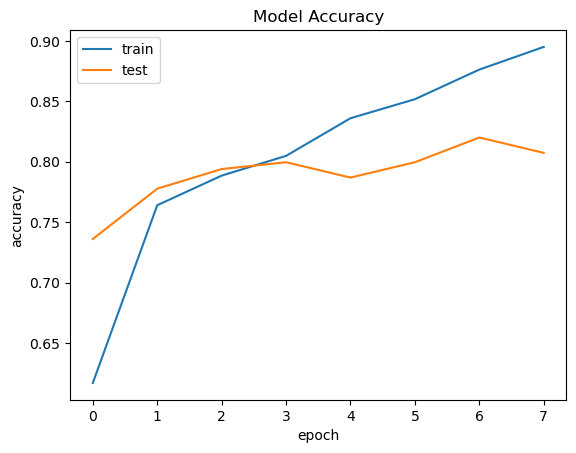

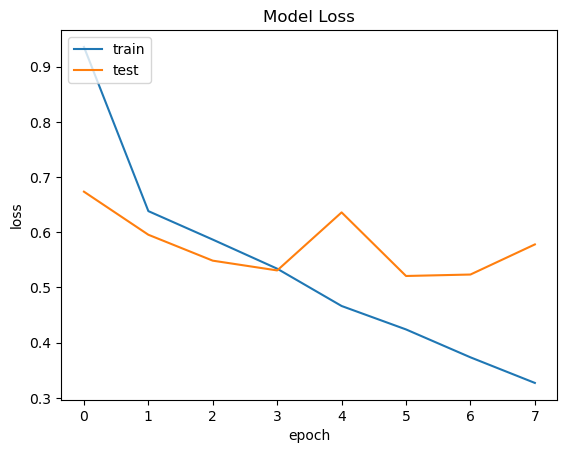

In [13]:
#Run model! 
#OLD NEURAL NETWORK!!!!!
model = Sequential()
model.add(LSTM(64, return_sequences=True,input_shape=(30, inputDim))) #inputDim = 2048/9
model.add(Dropout(0.4))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(64)) 
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=8, batch_size=64)
print(model.summary())
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
saveModel = model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 2048)]   0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 30, 64)       540928      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 30, 64)       33024       lstm_3[0][0]                     
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 64)           33024       lstm_4[0][0]                     
____________________________________________________________________________________________

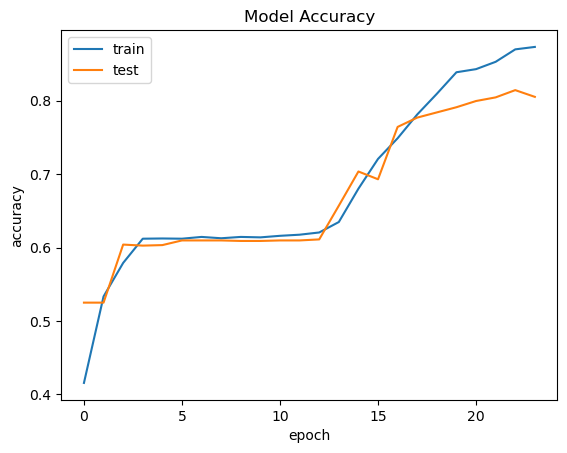

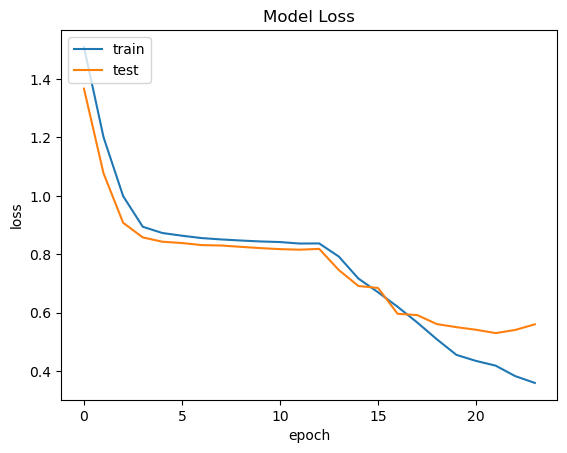

In [14]:
###NEW MODEl that incorporates Markov info!

model = Model()
input1 = Input(shape=(30,2048))
input2 = Input(shape=(5,))
output = LSTM(64, return_sequences=True)(input1)
output = LSTM(64, return_sequences=True)(output)
output = LSTM(64)(output)
output = Dense(5, activation='softmax')(output)

output = Concatenate()([output, input2])

output = Dense(10, activation="relu")(output)
output = Dense(25, activation="relu")(output)
output = Dense(20, activation="relu")(output)
output = Dense(15, activation="relu")(output)
output = Dense(5, activation='softmax')(output)


# output = Dense(5, activation='softmax')(output)
# model.add(LSTM(64, return_sequences=True,input_shape=(30, inputDim))) #inputDim = 2048/9
# model.add(Dropout(0.3))
# model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(64)) 
# model.add(Dropout(0.3))
# model.add(Dense(5, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model = Model(inputs=[input1, input2], outputs=output)

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit((X_train_pad, trainMarkov), y_train, validation_data=((X_test_pad, testMarkov) , y_test), epochs=24, batch_size=64)

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
##display accuracy of model for each play type
types = ['K', 'R', 'P', 'X/F', 'U']
corrects =  [0.0 for _ in range(len(types))]
tot = 0
totCor = 0
counts = [0.0 for _ in range(len(types))]
for idx in range(len(y_test)):
    counts[np.argmax(y_test[idx])] += 1.0
    tot += 1
    pred = model.predict((X_test_pad[idx: idx+1], testMarkov[idx: idx + 1])) #uncomment this line if u want to test the new, combined Neural Net!
    #pred = model.predict(X_test_pad[idx:idx+1]) #Uncomment this line if u want to test the old Neural Network!
#     markov = testMarkov[idx: idx + 1] 

        
    if np.argmax(y_test[idx]) == np.argmax(pred):
        corrects[np.argmax(y_test[idx])] += 1.0
        totCor += 1


for i in range(len(types)):
    print(types[i] + " Accuracy: %.2f%%" % (100 * corrects[i]/counts[i]))

K Accuracy: 83.33%
R Accuracy: 85.08%
P Accuracy: 77.96%
X/F Accuracy: 87.36%
U Accuracy: 85.92%


In [ ]:
# K Accuracy: 83.33%
# R Accuracy: 85.08%
# P Accuracy: 77.96%
# X/F Accuracy: 87.36%
# U Accuracy: 85.92%